In [105]:

%load_ext autoreload
%autoreload 2

import os
import re
import traceback
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import torch

import gpytorch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pyro
import pyro.distributions as dist
from pyro.infer import Predictive
from gpytorch.kernels import ScaleKernel, RBFKernel, PeriodicKernel, \
    LinearKernel, ProductKernel, AdditiveKernel, MaternKernel, SpectralMixtureKernel, \
        PiecewisePolynomialKernel, PolynomialKernel, RQKernel, RFFKernel
from gpytorch.priors import GammaPrior, HorseshoePrior

import tqdm
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(0,"../../")

import itertools
import collections

# set plotting theme
from matplotlib.ticker import MultipleLocator
from cycler import cycler
plt.style.use('default')
# color_cycle = ['#348ABD', '#E24A33', '#988ED5', '#777777', '#FBC15E', '#8EBA42', '#FFB5B8']
# default_color_cycle = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
rcparam_update = {
    "axes.titlesize": 'large',
    "axes.labelsize": "large",
    "figure.labelsize": "large", 
    "figure.titlesize": "large",
    'legend.fontsize': 'large',
    'legend.title_fontsize': 'large',
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    # 'axes.prop_cycle': cycler('color', color_cycle),
    'axes.facecolor': '#fdfdff',
    "font.family": "FreeSans",
    'figure.figsize': [6.4, 4.8], # default
}
plt.rcParams.update(rcparam_update)
save_image_path = "/mnt/c/Users/huyca/OneDrive/Thesis_tex/Figures/ace0/model"
dpi = 600
savefig = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [106]:
def load_data(run_number, load="run"):
    
    agents = {
        "viper": "Blue",
        "cobra": "Red",
    }
    run_str = '0000'
    run_str = run_str[:-len(str(run_number))] + str(run_number)
    if load == "run":
        pattern = rf'^(.*?{run_str}.*?_run\.csv)$'
        rename = {"contact_ata": "ata", "contact_aa": "aa", "contact_range": "range"}
        agent_col = "callsign"
    elif load == "weapons":
        pattern = rf'^(.*?{run_str}.*?_weapons\.csv)$'
        rename = dict()
        agent_col = "launcher_callsign"
    else:
        raise ValueError("invalid load type")
    
    filenames = os.listdir(os.path.join(path, "runs"))
    matching_files = [f for f in filenames if re.match(pattern, f)][0]

    df = pd.read_csv(os.path.join(path,"runs", matching_files))
    df[agent_col] = df[agent_col].map(agents)
    df.rename(rename, axis=1, inplace=True)
    print("loaded csv:", matching_files)
    return df

In [107]:
outcome_map = {
    "VIPER_WIN": "Blue Win",
    "BOTH_SURVIVED": "Both Survived",
    "MUTUAL_KILL": "Both Killed",
    "COBRA_WIN": "Red Win",
}
path = "../../ace0/msl_evasion-003"
# path = "../../ace0/msl_evasion-005/msl_evasion-case-5.csv"
df = pd.read_csv(os.path.join(path, "msl_evasion-003.csv"))
df.outcome = df.outcome.map(outcome_map)

In [108]:
def plot_trajectory(summary_df, run_df, run_number, weapons_df, max_timestep=None, time_annotate=None, ax=None):
    
    if not max_timestep:
        max_timestep = run_df.timestep.max()
    run_df = run_df[run_df.timestep <= max_timestep]
    weapons_df = weapons_df[weapons_df.timestep <= max_timestep]
    if not ax:
        fig, ax = plt.subplots(figsize=(5,5))
    
    # runs
    red_df = run_df[run_df.callsign=="Red"]
    blue_df = run_df[run_df.callsign=="Blue"]
    red_x = red_df.x.values
    red_y = red_df.y.values
    blue_x = blue_df.x.values
    blue_y = blue_df.y.values
    # weapons
    red_weapon_df = weapons_df[weapons_df.launcher_callsign=="Red"]
    blue_weapon_df = weapons_df[weapons_df.launcher_callsign=="Blue"]
    red_wpn_x = red_weapon_df.wpn_x.values
    red_wpn_y = red_weapon_df.wpn_y.values
    blue_wpn_x = blue_weapon_df.wpn_x.values
    blue_wpn_y = blue_weapon_df.wpn_y.values
    
    # outcome
    outcome = summary_df[summary_df.run_number==run_number].outcome.values[0]
    agent_killed = False
    
    if outcome == "Blue Win":
        unpack = red_df[red_df.alive==0][["timestep", "x", "y"]].values
        c = "Red"
        agent_killed = True
    elif outcome == "Red Win":
        unpack = blue_df[blue_df.alive==0][["timestep", "x", "y"]].values
        c = "Blue"
        agent_killed = True
        
    if agent_killed:
        assert unpack.size > 0, "max_timestep is less than time agent killed."
        time_killed, x_killed, y_killed = unpack[0]
        ax.scatter(x_killed, y_killed, s=50, color=c, marker="x")
        print(f"Outcome: {outcome}, time_killed: {time_killed}")
    
    # # scatter
    # alpha = np.linspace(0.15,.5,len(red_y))
    # alpha = alpha**2
    # # plot agent trajectory
    # ax.scatter(red_x, red_y, alpha=alpha, s=.1, label="", color="red")
    # ax.scatter(blue_x, blue_y, alpha=alpha, s=.1, label="", color="blue")
    # # plot weapon trajectory
    # ax.scatter(red_wpn_x, red_wpn_y, alpha=alpha, s=.1, label="", color="red", marker=",")
    # ax.scatter(blue_wpn_x, blue_wpn_y, alpha=alpha, s=.1, label="", color="blue", marker=",")
    
    # lineplot
    alpha = .5
    lw = 1.5
    ls = (0, (3, 1, 1, 1, 1, 1))
    # plot agent trajectory
    ax.plot(red_x, red_y, alpha=alpha, lw=lw, label="", color="red")
    ax.plot(blue_x, blue_y, alpha=alpha, lw=lw, label="", color="blue")
    # plot weapon trajectory
    ax.plot(red_wpn_x, red_wpn_y, alpha=alpha, lw=lw/2, label="", color="red", ls=ls)
    ax.plot(blue_wpn_x, blue_wpn_y, alpha=alpha, lw=lw/2, label="", color="blue", ls=ls)
    
    if time_annotate is None:
        time_annotate = np.arange(0,max_timestep+1, 50)

    red_annotate = red_df[red_df.timestep.isin(time_annotate)][["x","y"]].values
    red_annotate_x, red_annotate_y = red_annotate[:,0], red_annotate[:,1]

    blue_annotate = blue_df[blue_df.timestep.isin(time_annotate)][["x","y"]].values
    blue_annotate_x, blue_annotate_y = blue_annotate[:,0], blue_annotate[:,1]

    fs_annotate = 8
    xpad = 1500
    for t, text in enumerate(time_annotate):
        if t == 0:
            text = "Start"
        ax.annotate(text, (red_annotate_x[t] + xpad, red_annotate_y[t]), c="red", ha='center', va='bottom', fontsize=fs_annotate)
        ax.annotate(text, (blue_annotate_x[t] + xpad, blue_annotate_y[t]), c="blue", ha='center', va='bottom', fontsize=fs_annotate)
    
    ax.tick_params("both", labelsize=8)
    ax.set_xlabel("x", fontsize=9)
    ax.set_ylabel("y", fontsize=9)
    
    return outcome

In [109]:
def plot_posture(df, max_timestep=None, time_annotate=None, ax=None):
    if not max_timestep:
        max_timestep = df.timestep.max()
    df = df[df.timestep <= max_timestep]
    if not ax:
        fig, ax = plt.subplots(figsize=(5,5))
        
    red_df = df[df.callsign=="Red"]
    blue_df = df[df.callsign=="Blue"]
    
    major_angle = np.arange(0,181,30)
    ticklabels =  [r"${}\degree$".format(angle) for angle in major_angle]

    red_ab_aa = np.abs(red_df.aa.values)
    red_ab_ata = np.abs(red_df.ata.values)

    blue_ab_aa = np.abs(blue_df.aa.values)
    blue_ab_ata = np.abs(blue_df.ata.values)

    alpha = .5
    lw = 1.5
    
    ax.plot(red_ab_aa, red_ab_ata, alpha=alpha, lw=lw, color="red")
    ax.plot(blue_ab_aa, blue_ab_ata, alpha=alpha, lw=lw, color="blue")
    ax.set_xticks(major_angle)
    ax.set_yticks(major_angle)
    ax.set_xticklabels(ticklabels, fontsize=8)
    ax.set_yticklabels(ticklabels, fontsize=8)
    ax.set_xlabel("|AA|", fontsize=9)
    ax.set_ylabel("|ATA|", fontsize=9)

    [ax.axhline(y,color='k', lw=.5, linestyle='-', alpha=.2) for y in ax.get_yticks()]
    [ax.axvline(x,color='k', lw=.5, linestyle='-', alpha=.2) for x in ax.get_xticks()]

    ax.axhline(90,color='k', lw=.85, linestyle='-', alpha=.99)
    ax.axvline(90,color='k', lw=.85, linestyle='-', alpha=.99)
    
    if time_annotate is None:
        time_annotate = np.arange(0,max_timestep+1, 50)

    red_annotate = np.abs(red_df[red_df.timestep.isin(time_annotate)][["aa","ata"]].values)
    red_annotate_x, red_annotate_y = red_annotate[:,0], red_annotate[:,1]

    blue_annotate = np.abs(blue_df[blue_df.timestep.isin(time_annotate)][["aa","ata"]].values)
    blue_annotate_x, blue_annotate_y = blue_annotate[:,0], blue_annotate[:,1]

    fs_annotate = 9
    for t, text in enumerate(time_annotate):
        if text == 0:
            ax.annotate("Start", (175,0), c="k", ha='right', va='bottom', fontsize=fs_annotate, weight="bold")
        else:
            ax.annotate(text, (red_annotate_x[t], red_annotate_y[t]), c="red", ha='center', va='bottom', fontsize=fs_annotate)
            ax.annotate(text, (blue_annotate_x[t], blue_annotate_y[t]), c="blue", ha='left', va='bottom', fontsize=fs_annotate)

    alpha_pos = .6
    ax.annotate("Neutral", (45, 135), c="k", ha='center', va='center', fontsize=12, alpha=alpha_pos)
    ax.annotate("Defense", (135, 135), c="k", ha='center', va='center', fontsize=12, alpha=alpha_pos)
    ax.annotate("Head-On", (135, 45), c="k", ha='center', va='center', fontsize=12, alpha=alpha_pos)
    ax.annotate("Offense", (45, 45), c="k", ha='center', va='center', fontsize=12, alpha=alpha_pos)
    
    ep = .5
    ax.set_xlim(-ep,180+ep)
    ax.set_ylim(-ep,180+ep)

In [110]:

def plot_trajectory_posture(summary_df, run_df=None, weapons_df=None, run_number=None, max_timestep=None, time_annotate=None, ax=None, savefig=False, **kwargs):
    if (not run_df and not run_number):
        raise ValueError("run_df and run_number cannot be empty.")
    
    if not run_df:
        run_df = load_data(run_number)
        weapons_df = load_data(run_number, load="weapons")
    
    if not max_timestep:
        max_timestep = run_df.timestep.max()
        
    run_df = run_df[run_df.timestep <= max_timestep]
    weapons_df = weapons_df[weapons_df.timestep <= max_timestep]
    fig = None
    if not ax:
        fig, ax = plt.subplots(ncols=2, figsize=(11,5))
    if time_annotate is None:
        time_annotate = np.arange(0,max_timestep+1, 50)
    
    outcome = plot_trajectory(summary_df=summary_df, run_df=run_df, run_number=run_number, weapons_df=weapons_df, max_timestep=max_timestep, time_annotate=time_annotate, ax=ax[0])
    plot_posture(run_df, max_timestep, time_annotate=time_annotate, ax=ax[1])
    
    if fig:
        ax[0].set_title("Trajectory", fontsize=9, pad=10)
        ax[1].set_title("Angular Posture", fontsize=9, pad=10)
        fig.suptitle(f"Run no.: {run_number}, Outcome: {outcome}", fontsize=9, weight="bold")
        fig.subplots_adjust(wspace=.3)
        
    if savefig:
        filename = kwargs["filename"]
        assert (filename is not None) and (filename[-4:] in[".pdf", ".png"])
        if os.path.exists(os.path.join(save_image_path, filename[:-4] + ".png")):
            os.remove(os.path.join(save_image_path, filename[:-4] + ".png"))
            print("Deleted file:", filename[:-4] + ".png")
        fig.savefig(os.path.join(save_image_path, filename), dpi=dpi, pad_inches=0, bbox_inches='tight')

In [111]:
# run_numbers of interest:
run = [
    6, # both survived, red in winning posture
    140,
    93,
    174, # good scenario
    150,
]

loaded csv: 20230426_125613_0006_ace_zero_run.csv
loaded csv: 20230426_124249_0006_ace_zero_run_weapons.csv


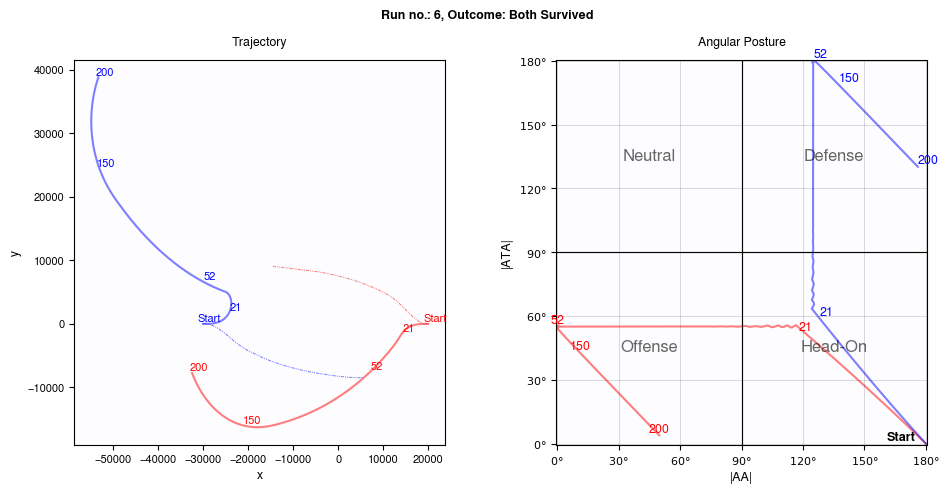

In [112]:
time_annotate = [0, 21, 52, 150, 200]
plot_trajectory_posture(df, run_number=6,max_timestep=200, time_annotate=time_annotate, savefig=savefig, filename="run6.pdf")

loaded csv: 20230426_130127_0093_ace_zero_run.csv
loaded csv: 20230426_130127_0093_ace_zero_run_weapons.csv
Outcome: Blue Win, time_killed: 58.1


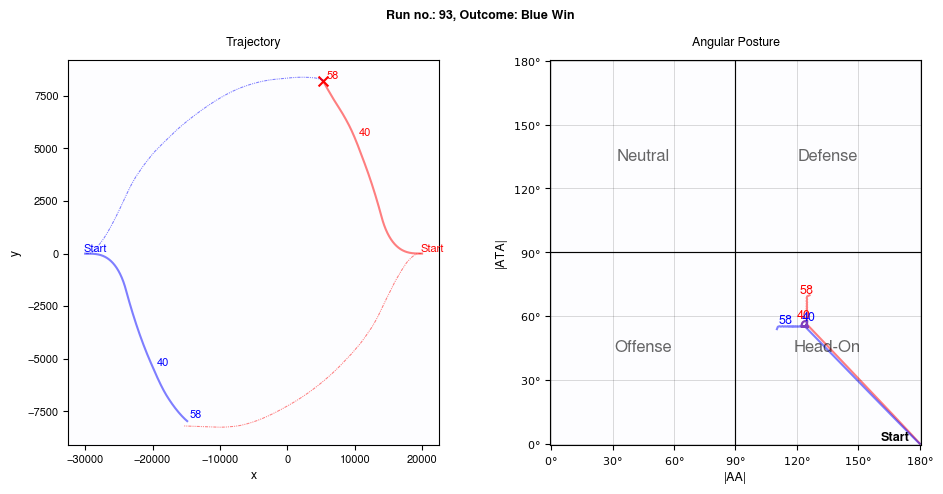

In [113]:
time_annotate = [0, 40, 58]
plot_trajectory_posture(df, run_number=93,max_timestep=59, time_annotate=time_annotate, savefig=savefig, filename="run93.pdf")

loaded csv: 20230426_130449_0150_ace_zero_run.csv
loaded csv: 20230426_130449_0150_ace_zero_run_weapons.csv
Outcome: Red Win, time_killed: 73.5


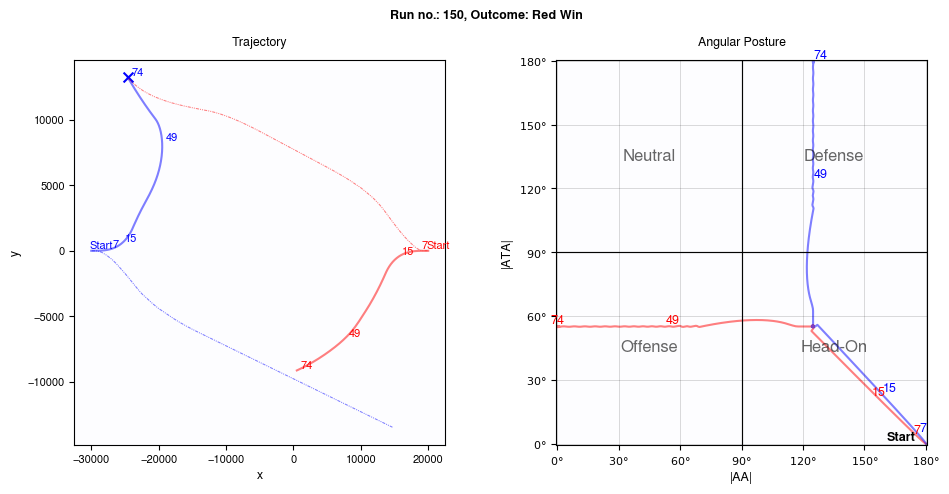

In [114]:
time_annotate = [0, 7, 15, 49, 74]
plot_trajectory_posture(df, run_number=150,max_timestep=74, time_annotate=time_annotate, savefig=savefig, filename="run150.pdf")

loaded csv: 20230426_130612_0174_ace_zero_run.csv
loaded csv: 20230426_130612_0174_ace_zero_run_weapons.csv
Outcome: Red Win, time_killed: 69.8


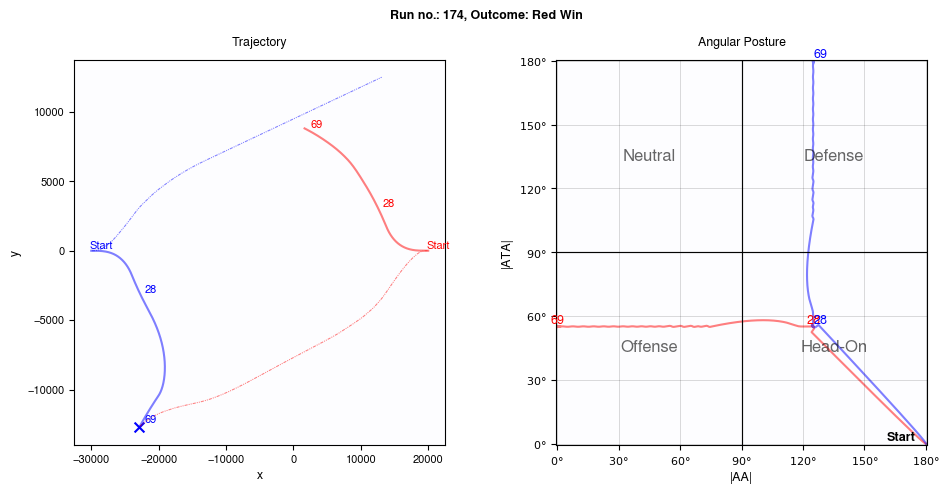

In [115]:
time_annotate = [0, 28, 69]
plot_trajectory_posture(df, run_number=174,max_timestep=70, time_annotate=time_annotate, savefig=savefig, filename="run174.pdf")

In [116]:
files = os.listdir(save_image_path)
files.sort(key=lambda f: os.path.getmtime(os.path.join(save_image_path,f)))

In [117]:
for f in files:
    fstring = """
    \\begin{figure}[H]
        \centering
        \includegraphics[width=.75\\textwidth]{/ace0/model/""" + f"{f}" + "}" + """
        \caption{X.}
        \label{X}
    \end{figure}
    """
    print(fstring)


    \begin{figure}[H]
        \centering
        \includegraphics[width=.75\textwidth]{/ace0/model/kernel3_y1_agreement.png}
        \caption{X.}
        \label{X}
    \end{figure}
    

    \begin{figure}[H]
        \centering
        \includegraphics[width=.75\textwidth]{/ace0/model/kernel3_y4_agreement.png}
        \caption{X.}
        \label{X}
    \end{figure}
    

    \begin{figure}[H]
        \centering
        \includegraphics[width=.75\textwidth]{/ace0/model/kernel3_y5_agreement.png}
        \caption{X.}
        \label{X}
    \end{figure}
    

    \begin{figure}[H]
        \centering
        \includegraphics[width=.75\textwidth]{/ace0/model/kernel3_y_agreement_mean.png}
        \caption{X.}
        \label{X}
    \end{figure}
    

    \begin{figure}[H]
        \centering
        \includegraphics[width=.75\textwidth]{/ace0/model/kernel3_y2_msce.png}
        \caption{X.}
        \label{X}
    \end{figure}
    

    \begin{figure}[H]
        \centering
        \includegraphics

#### EDA of case5

In [118]:
input_set1 = [
    "lognorm_viper_launch_range",
    "lognorm_viper_briefed_evasion_range",
    "lognorm_cobra_launch_range",
    "lognorm_cobra_briefed_evasion_range",
]

input_set2 = [
    "norm_viper_launch_range",
    "norm_viper_briefed_evasion_range",
    "norm_cobra_launch_range",
    "norm_cobra_briefed_evasion_range",
]

input_set3 = [
    "launch_range_diff",
    "briefed_evasion_range_diff",
]

input_set4 = [
    "briefed_launch_range_diff",
    "briefed_evasion_range_diff",
]

input_set5 = [
    "lognorm_viper_briefed_launch_range",
    "lognorm_viper_briefed_evasion_range",
    "lognorm_cobra_briefed_launch_range",
    "lognorm_cobra_briefed_evasion_range",
]

input_set6 = [
    "viper_launched",
    "lognorm_viper_briefed_launch_range",
    "lognorm_viper_briefed_evasion_range",
    "cobra_launched",
    "lognorm_cobra_briefed_launch_range",
    "lognorm_cobra_briefed_evasion_range",
]

input_set7 = [
    "norm_viper_launch_range",
    "norm_viper_briefed_evasion_range",
    "norm_cobra_launch_range",
    "norm_cobra_briefed_evasion_range",
    "briefed_launch_range_diff",
    "briefed_evasion_range_diff",
]

input_set8 = [
    "norm_viper_briefed_launch_range",
    "norm_viper_briefed_evasion_range",
    "norm_cobra_briefed_launch_range",
    "norm_cobra_briefed_evasion_range",
]

viper_portion_cols = [
    'viper_p_NEUTRAL', 
    'viper_p_DEFENSIVE',
    'viper_p_HEADON', 
    'viper_p_OFFENSIVE'
]

cobra_portion_cols = [
    'cobra_p_NEUTRAL', 
    'cobra_p_DEFENSIVE',
    'cobra_p_HEADON', 
    'cobra_p_OFFENSIVE'
]

response1 = ["outcome"]
response2 = ["outcome"] + viper_portion_cols
response3 = ["outcome"] + viper_portion_cols + cobra_portion_cols
response4 = ["outcome"] + viper_portion_cols + cobra_portion_cols + ["viper_launched"] + ["cobra_launched"]

In [119]:
path = "../../ace0/msl_evasion-005/msl_evasion-case-5_edited.csv"
df = pd.read_csv(path, index_col=0)
df = df[input_set8 + response4]

In [120]:
rename_dict = {col: col.replace('viper', 'blue') for col in df.columns if 'viper' in col}
df.rename(columns=rename_dict, inplace=True)

rename_dict = {col: col.replace('cobra', 'red') for col in df.columns if 'cobra' in col}
df.rename(columns=rename_dict, inplace=True)

rename_dict = {col: col.replace('norm_', '') for col in df.columns if 'norm' in col}
df.rename(columns=rename_dict, inplace=True)

In [121]:
df["launch_range_diff"] = (df.blue_briefed_launch_range - df.red_briefed_launch_range)
df["evasion_range_diff"] = (df.blue_briefed_evasion_range - df.red_briefed_evasion_range)

df["blue_launch_red_evasion_range_diff"] = (df.blue_briefed_launch_range - df.red_briefed_evasion_range)
df["red_launch_blue_evasion_range_diff"] = (df.red_briefed_launch_range - df.blue_briefed_evasion_range)

In [122]:
outcome_map = {
    3: "Blue Win",
    2: "Both Survived",
    1: "Both Killed",
    0: "Red Win",
}

df["outcomes"] = df.outcome.map(outcome_map)

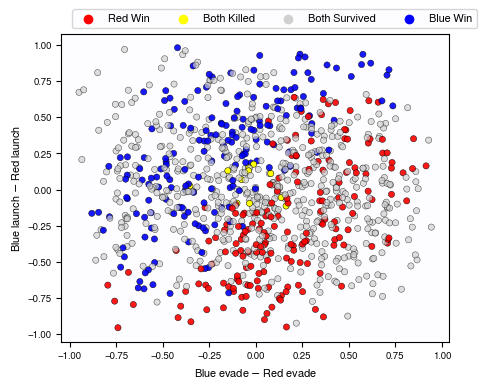

In [123]:

color_map = {
    3: "blue",
    2: "#D0D0D0",
    1: "yellow",
    0: "red",
}


alpha_map = {
    3: .9,
    2: .7,
    1: 1,
    0: .9,
}


# colors = ["blue", "yellow", "#D0D0D0", "red"]
labels = ["Red Win", "Both Killed", "Both Survived", "Blue Win"]

fig, ax = plt.subplots(figsize=(5,4))

sns.scatterplot(data=df, y="launch_range_diff", x="evasion_range_diff", hue="outcome", ax=ax, edgecolor="k", s=20, palette=color_map, alpha=df.outcome.map(alpha_map))

handles, _ = ax.get_legend_handles_labels()
# order = [0,2,1,3]
# handles = [handles[idx] for idx in order]
ax.legend(handles=handles, labels=labels, loc='lower center', bbox_to_anchor=(.55, 1), ncol=4, fontsize=8)
ax.tick_params(axis='both', which='major', labelsize=7)
ax.set_ylabel("Blue launch $-$ Red launch", fontsize=8)
ax.set_xlabel("Blue evade $-$ Red evade", fontsize=8)


if savefig:
    if os.path.exists("launch_evade_diff_vs_outcomes.png"):
        os.remove(os.path.join(save_image_path, "launch_evade_diff_vs_outcomes.png"))
    fig.savefig(os.path.join(save_image_path, "launch_evade_diff_vs_outcomes.pdf"), dpi=dpi, pad_inches=0, bbox_inches='tight')

In [124]:
df.columns

Index(['blue_briefed_launch_range', 'blue_briefed_evasion_range',
       'red_briefed_launch_range', 'red_briefed_evasion_range', 'outcome',
       'blue_p_NEUTRAL', 'blue_p_DEFENSIVE', 'blue_p_HEADON',
       'blue_p_OFFENSIVE', 'red_p_NEUTRAL', 'red_p_DEFENSIVE', 'red_p_HEADON',
       'red_p_OFFENSIVE', 'blue_launched', 'red_launched', 'launch_range_diff',
       'evasion_range_diff', 'blue_launch_red_evasion_range_diff',
       'red_launch_blue_evasion_range_diff', 'outcomes'],
      dtype='object')